In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# %cd /content/drive/MyDrive/RIVF2021/RIVF2021-MC-OCR/
# %cd data/mcocr2021_public_train_test_data/mcocr_public_train_test_shared_data/mcocr_train_data 
# !mkdir annotations

In [ ]:
%cd /content/drive/MyDrive/RIVF2021/RIVF2021-MC-OCR/

/content/drive/MyDrive/RIVF2021/RIVF2021-MC-OCR


In [ ]:
import os
import cv2
from pycocotools.coco import COCO
from sklearn.model_selection import train_test_split
import json

import tqdm


In [ ]:
annotation_path = '/content/drive/MyDrive/RIVF2021/RIVF2021-MC-OCR/data/mcocr2021_public_train_test_data/mcocr_public_train_test_shared_data/mcocr_train_data/annotations/instances_default.json'
image_folder = '/content/drive/MyDrive/RIVF2021/RIVF2021-MC-OCR/data/mcocr2021_public_train_test_data/mcocr_public_train_test_shared_data/mcocr_train_data/train_images'
mask_folder = '/content/drive/MyDrive/RIVF2021/RIVF2021-MC-OCR/data/mask'
export_data_path = '/content/drive/MyDrive/RIVF2021/RIVF2021-MC-OCR/data/data.json'
export_data_train_path = '/content/drive/MyDrive/RIVF2021/RIVF2021-MC-OCR/data/train.json'
export_data_val_path = '/content/drive/MyDrive/RIVF2021/RIVF2021-MC-OCR/data/val.json'
export_data_test_path = '/content/drive/MyDrive/RIVF2021/RIVF2021-MC-OCR/data/test.json'

In [ ]:
def read_json(path):
    with open(path, "r") as File:
        data = json.load(File)
        return data

In [ ]:
def export_coco_format_data(annotation_path= annotation_path,
                            image_folder= image_folder,
                            mask_folder= mask_folder,
                            export_data_path= export_data_path):
    coco = COCO(annotation_path)
    anns_ids = coco.getAnnIds()
    anns = coco.loadAnns(anns_ids)

    img_info = coco.imgs
    # group all annotations have same image id
    groups = {}
    for ann in anns:
        image_id = ann['image_id']
        if image_id not in groups:
            groups[image_id] = [ann]
        else:
            groups[image_id].append(ann)

    # save mask in for each image
    image_label_pairs = {}
    for image_id, ann_list in tqdm.tqdm(groups.items()):
        image_mask = None
        for ann in ann_list:
            if image_mask is None:
                image_mask = coco.annToMask(ann)
            else:
                image_mask += coco.annToMask(ann)
            
            bbox = ann['bbox']
            category_id = ann['category_id']
            bbox.append(category_id)
            box_info = bbox
          
        # print(image_mask.shape)
        image_mask[image_mask >= 1] = 1
        filename = img_info[image_id]['file_name']
        name, _ = os.path.splitext(filename)
        mask_path = os.path.join(mask_folder, name + '.png')
        cv2.imwrite(mask_path, image_mask)

        image_path = os.path.join(image_folder, filename)
        if not os.path.exists(image_path):
            raise ValueError('not found', image_path)
        image_label_pairs[image_path] =  (mask_path, box_info)

    with open(export_data_path, 'w') as f:
        json.dump(image_label_pairs, f)


In [ ]:
def split_data(all_data_json_path= export_data_path, ratio=[0.8, 0.15, 0.05]):
    with open(all_data_json_path, 'r') as f:
        data = json.load(f)

    all_image_paths = []
    all_mask_paths = []
    for image_path, mask in data.items():
        all_image_paths.append(image_path)
        all_mask_paths.append((mask[0], mask[1]))

    normalized_ratio = [e / sum(ratio) for e in ratio]
    train_image_paths, vt_image_paths, \
    train_mask_paths, vt_mask_paths = train_test_split(all_image_paths, all_mask_paths,
                                                       test_size=1 - normalized_ratio[0])
    val_image_paths, test_image_paths, \
    val_mask_paths, test_mask_paths = train_test_split(vt_image_paths, vt_mask_paths,
                                                       test_size=normalized_ratio[-1] / (1 - normalized_ratio[0]))

    def save_data(image_paths, mask_paths, save_path):
        data_dict = {}
        for image_path, mask_path in zip(image_paths, mask_paths):
            data_dict[image_path] = mask_path

        with open(save_path, 'w') as f:
            json.dump(data_dict, f)

    save_data(train_image_paths, train_mask_paths, export_data_train_path)
    save_data(val_image_paths, val_mask_paths, export_data_val_path)
    save_data(test_image_paths, test_mask_paths, export_data_test_path)


In [ ]:
os.mkdir("./data/mask")
export_coco_format_data(annotation_path, image_folder, mask_folder, export_data_path)
split_data()

  0%|          | 4/1155 [00:00<00:29, 39.20it/s]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


100%|██████████| 1155/1155 [00:19<00:00, 59.93it/s]


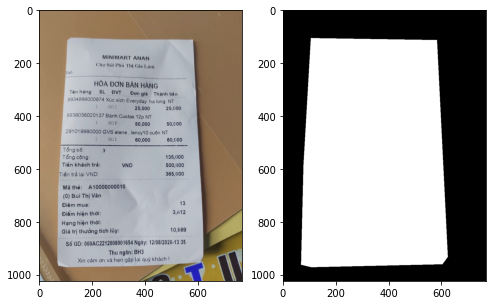

bbox:  [68.1, 106.01, 555.67, 866.03]
category:  1


In [ ]:
import cv2 
import matplotlib.pyplot as plt
import random

data = read_json(export_data_val_path)
keys = list(data.keys())

index = random.randint(0,len(keys)-1)
fig=plt.figure(figsize=(8, 8))

show_image = cv2.imread(keys[index])
fig.add_subplot(1, 2, 1)
plt.imshow(show_image)

show_seg = cv2.imread(list(data.values())[index][0])
fig.add_subplot(1, 2, 2)
plt.imshow(show_seg * 255)

plt.show() 

print("bbox: ", list(data.values())[index][1][:-1])
print("category: ", list(data.values())[index][1][-1])